# Количество заказов такси на следующий час

<div style="border:solid gray 2px; padding: 20px">  
    
<b> В данном Проекте</b>  для того, чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  
    
Инструкция по выполнению проекта  

1. Загрузка данных и ресемплирование по одному часу.  
2. Анализ.  
3. Обучение разных моделей с различными гиперпараметрами. Выделить тестовую выборку размером 10% от исходных данных.  
4. Проверка данных на тестовой выборке и выводы.


## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNetCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

RANDOM = 12345

In [2]:
pth1 = '/Users/macbookair13i5/Desktop/datasets/Datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'
pth3 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col = [0], parse_dates = [0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col = [0], parse_dates = [0])
elif os.path.exists(pth3):
    df = pd.read_csv(pth3, index_col = [0], parse_dates = [0])
else:
    display('Something is wrong')
    
df.sort_index(inplace = True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Проверим последовательность даты и времени

df.index.is_monotonic

True

In [5]:
print(f'Данные за период с {df.index.min()} по {df.index.max()}')

Данные за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Видим что временной интервал составляет 10 минут, перегруппируем временной ряд в интервал 1 час

### Resampling по одному часу

In [7]:
# Resampling по одному часу

df = df.resample('1H').sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


---

## Анализ данных

### Временной ряд и скользящее среднее

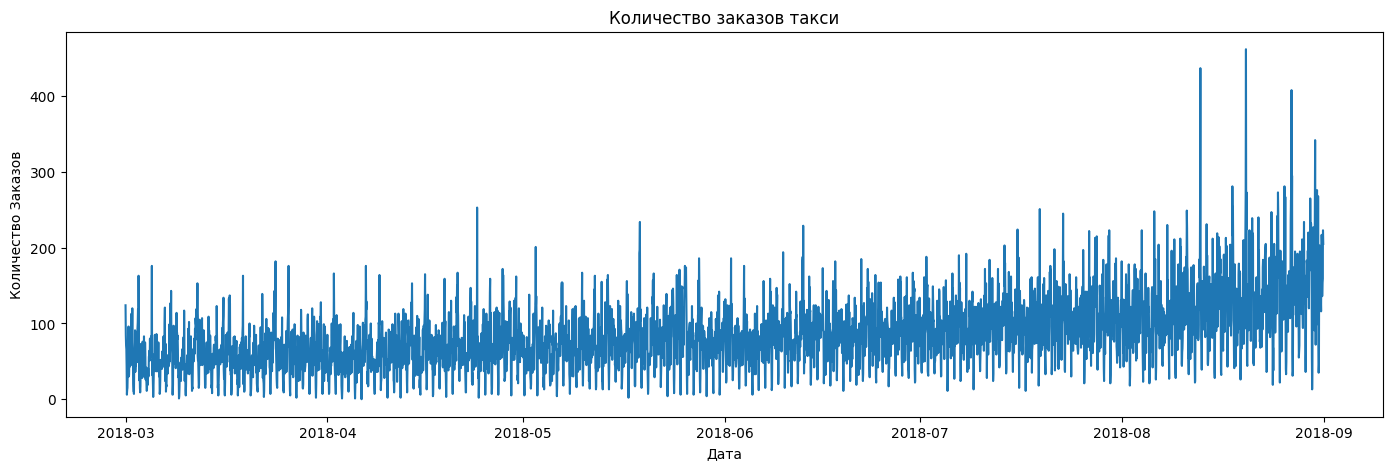

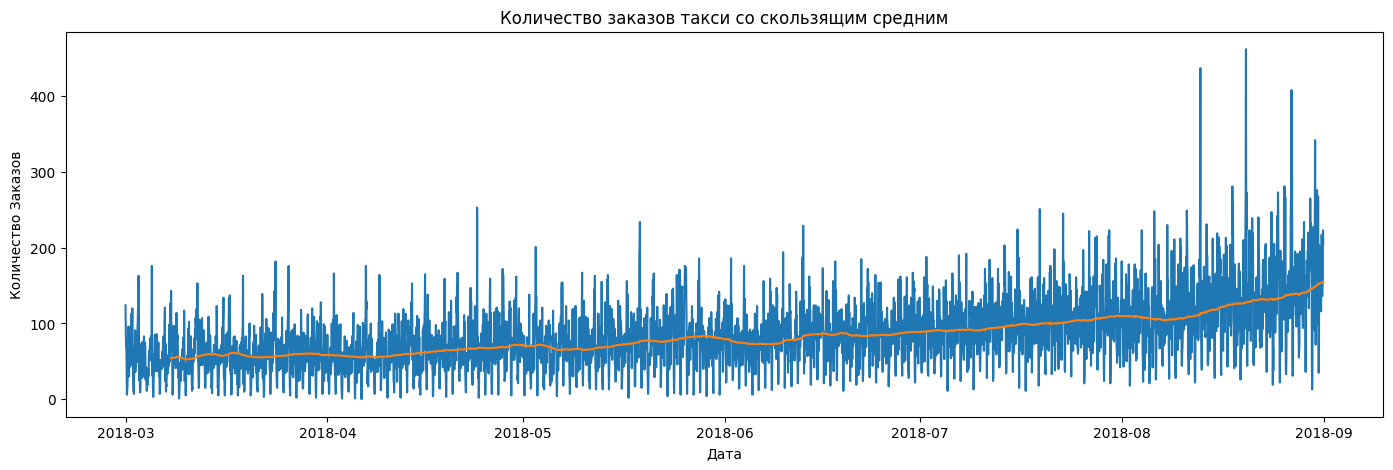

In [10]:
# Посмотрим на временной ряд

fig,ax = plt.subplots(figsize = (17,5))
ax.plot(df)
plt.title('Количество заказов такси')
plt.ylabel('Количество Заказов')
plt.xlabel('Дата')
plt.show()

# Добавим скользящее среднее (24 часа в сутках * 7 дней недели)

df['rolling_mean'] = df.rolling(24 * 7).mean()

fig,ax = plt.subplots(figsize = (17,5))
ax.plot(df)
plt.title('Количество заказов такси со скользящим средним')
plt.ylabel('Количество Заказов')
plt.xlabel('Дата')

plt.show()


#### Тренд, Сезонность, Остаток

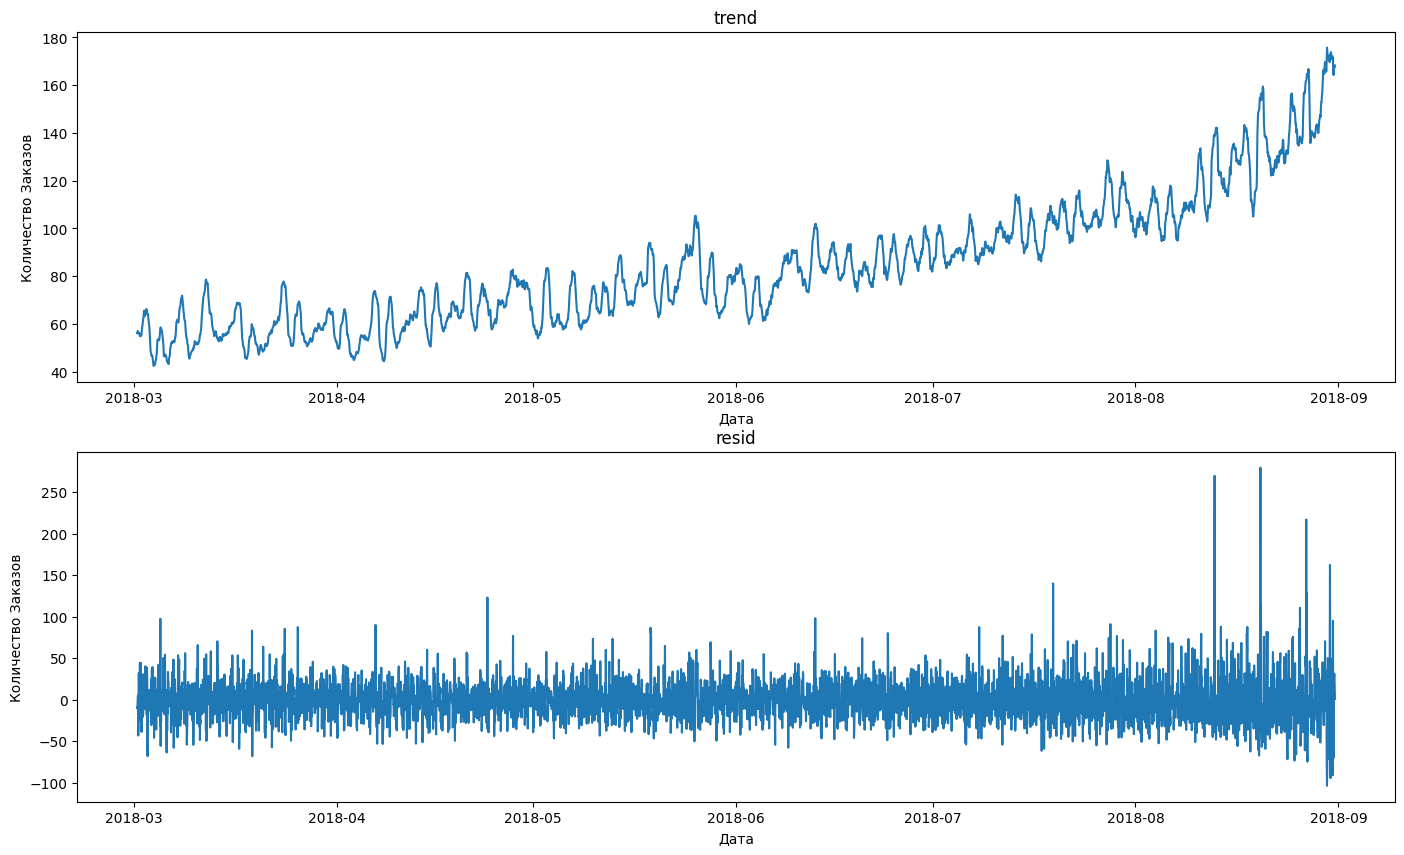

In [11]:
# Тренд, Сезонность, Остаток

decomposed = seasonal_decompose(df.drop(['rolling_mean'], axis = 1))
decomposed_list = [decomposed.trend, decomposed.resid]
decomposed_title_list = ['trend', 'resid']

fig,axs = plt.subplots(2, 1, figsize = (17, 10))

for n, values in enumerate(decomposed_list):
    axs[n].plot(values)
    axs[n].set_title(decomposed_title_list[n])
    axs[n].set_ylabel('Количество Заказов')
    axs[n].set_xlabel('Дата')

**Наблюдаем тренд** (плавное изменение среднего значения ряда без повторяющихся закономерностей) **увеличения количества заказов в течение всего времени!**

<AxesSubplot:xlabel='datetime'>

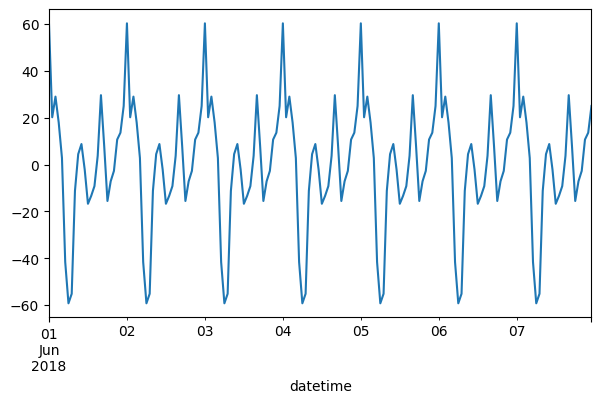

In [12]:
# Рассмотрим сезонность на примере короткого промежутка времени

fig = plt.subplots(figsize = (7,4))
decomposed.seasonal['2018-06-01' : '2018-06-07'].plot()

<AxesSubplot:xlabel='datetime'>

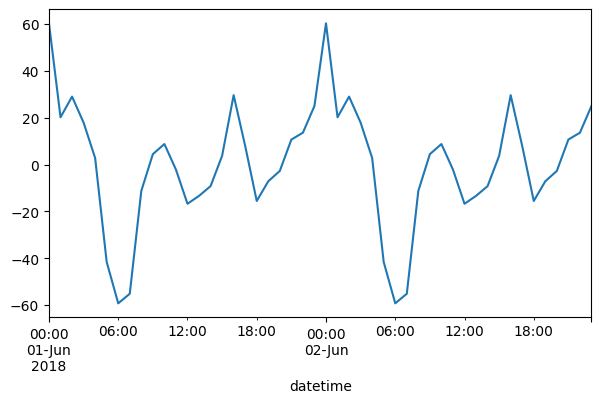

In [13]:
# Сезонность на примере 2 дней

fig = plt.subplots(figsize = (7,4))
decomposed.seasonal['2018-06-01' : '2018-06-02'].plot()

**Сезонность:** Пиковые значения количества заказов приходится в полночь. Минимальные значения в 6 часов утра

In [14]:
# Обозначение выводиммых переменных в тесте Дики-Фулера

adfuller_index = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical_values', 'icbest']

In [15]:
# Тест на стацинарность

ts = df['num_orders']
st_test = adfuller(ts, regression = 'ctt')

adfuller_test = pd.Series(st_test, index = adfuller_index)
adfuller_test

adf                                                       -10.891452
pvalue                                                           0.0
usedlag                                                           31
nobs                                                            4384
critical_values    {'1%': -4.373775161444573, '5%': -3.8337377543...
icbest                                                  41625.740406
dtype: object

Нам понадобятся значения:     
- P-value: 4.05493979282994e-17

In [16]:
if st_test[1] < 0.05:
    print('Временной ряд - стационарный')
else:
    print('Временной ряд нестационарный')

Временной ряд - стационарный


**Тест Дики-Фулера показал, что статистики не меняются в зависимости от времнеи**

---

## Добавление признаков

### Функция добавления признаков

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [18]:

df_final = df.copy()
df_final = make_features(df, 24, 7)

# Удалим пропуски от (Shift)
df_final = df_final.dropna()

### Признаки и Целевой признак

In [19]:
features = df_final.drop(['num_orders'], axis = 1)
target = df_final['num_orders']

##  Выделение тестовой выборки

In [20]:
# Выделим тестовую выборку размером 10% от исходных данных.

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle = False, test_size = 0.1)


In [21]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 28)
(440, 28)
(3952,)
(440,)


### Масштабирование признаков

In [22]:
# Масштабируем Признаки

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train), columns = features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features_test.columns)

## Обучение моделей

### "Быстрые" модели (LGBMRegressor, ElasticNetCV, LinearRegression)

In [23]:
# Запустим модели, которые обучаются очень быстро (без подбора гиперпараметров)

lgb = LGBMRegressor()
elastic_model = ElasticNetCV()
linear_model = LinearRegression()

model_list = [lgb, elastic_model, linear_model]
name_models = ['LGB', 'ElasticNetCV', 'LinRegression']

In [24]:
model_pred_list = []
rmse_list = []
time_fit_train = []
time_pred_train = []

for model in model_list:
    start_fit = time.time()
    model.fit(features_train, target_train)
    time_fit_train.append(time.time() - start_fit)
    
    start_pred = time.time()
    model_pred = model.predict(features_train)
    time_pred_train.append(time.time() - start_pred)
    model_pred_list.append(model_pred)
    #rmse = np.sqrt(mean_squared_error(target_train, model_pred))
    rmse_list.append(np.sqrt(mean_squared_error(target_train, model_pred)))

In [25]:
for n, model in enumerate(name_models):
    print(f'RMSE модели {model}: {rmse_list[n]}')

RMSE модели LGB: 12.403750998391066
RMSE модели ElasticNetCV: 26.224525091650914
RMSE модели LinRegression: 25.844386222563447


In [26]:
# Гиперпараметры для RandomForest

model_forest = RandomForestRegressor(random_state=RANDOM, n_jobs = -1)
params_forest = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 21),
    'max_features': ['log2', 'sqrt', None],
    'min_samples_leaf': range(1, 11),
    'bootstrap': [True, False]
}

### RandomForest

In [27]:
# Закоментировано. Выполнялось 1min 43s. лучшие гиперпараметры сохранены ниже

#%%time
## Поиск лучших гиперпараметров для RandomForest
#
#rs_forest = RandomizedSearchCV(model_forest, params_forest, cv=3, scoring = 'neg_mean_squared_error', error_score='raise', random_state=12345)
#rs_forest.fit(features_train, target_train)
#print(f'Лучшие параметры Леса: {rs_forest.best_params_}')

In [28]:
# Лучшие гиперпараметры для RandomForest (scoring = MSE)

rs_forest_best_params = {
    'n_estimators': [400],
    'min_samples_leaf': [3],
    'max_features': [None],
    'max_depth': [13],
    'bootstrap': [True]
}

In [29]:
tscv = TimeSeriesSplit(n_splits = 3)

In [30]:
# GridSearchCV для Random Forest

grid_forest = GridSearchCV(model_forest, rs_forest_best_params, scoring = 'neg_mean_squared_error', cv = tscv)
grid_forest.fit(features_train, target_train)
grid_forest_predict = grid_forest.predict(features_train)
grid_forest_rmse = np.sqrt(mean_squared_error(target_train, grid_forest_predict))
best_forest = grid_forest.best_estimator_

# Время обучения
start_train = time.time()
best_forest.fit(features_train, target_train)
time_fit_train.append(time.time() - start_train)
# Время предсказания
start_pred = time.time()
best_forest.predict(features_train)
time_pred_train.append(time.time() - start_pred)

print(f'RMSE Лучшей модели RandomForest: {grid_forest_rmse}')

RMSE Лучшей модели RandomForest: 12.305510276724037


### CatBoost

<div class="alert alert-info">
<b> Коментарий: </b>
При подборе гиперпараметров для CatBoost в RandomizedSCV  При обучении на выборке с добавленными признаками не удавалось завершить команду, выключался компьютер!  
    
- Гиперпараметры подбирал на начальных признаках  
- Лучшую модель обучал на выборке с добавленными признаками

In [31]:
features_train_catboost = features_train.copy()
features_test_catboost = features_test.copy()

In [32]:
# Удалим добавленные признаки - На наборе данных с дбавленными признаками компьютер не справляется с CatBoost (выключается)

features_train_catboost = features_train_catboost.loc[:,features_train_catboost.columns[:7]]
features_test_catboost = features_test_catboost.loc[:,features_test_catboost.columns[:7]]

In [33]:
# Подберем лучшие гиперпараметры (RandomizedSearchCV)

cat_models = CatBoostRegressor(loss_function = 'RMSE')
cat_params = {
    'depth': range(2,16),
    'learning_rate': np.arange(.01, 0.1, .01),
    'iterations': range(100, 1000, 100)
}

In [34]:
#%%time
## Закоментировано. Выполянлось 3min 43s. Лучшие Гиперпараметры Catboost Сохранены ниже
#
#best_CatBoost = None
#rs_CatBoost = RandomizedSearchCV(cat_models, cat_params, cv=3, scoring = 'neg_mean_squared_error', error_score='raise',  n_jobs = -1, random_state=RANDOM)
#
#rs_CatBoost.fit(features_train_catboost , target_train, verbose = False)
#print(f'Лучшие параметры CatBoost: {rs_CatBoost.best_params_}')

In [35]:
rs_CatBoost_best_params = {
    'depth': [3],
    'learning_rate': [0.06999999999999999],
    'iterations': [300]
}

In [36]:
# Поиск лучшей модели CatBoost

grid_cat = GridSearchCV(cat_models, rs_CatBoost_best_params, scoring = 'neg_mean_squared_error', cv = tscv)
grid_cat.fit(features_train, target_train , verbose = False)
grid_cat_predict = grid_cat.predict(features_train)
grid_cat_rmse = np.sqrt(mean_squared_error(target_train, grid_cat_predict))
best_CatBoost = grid_cat.best_estimator_

# Время обучения
start_train = time.time()
best_CatBoost.fit(features_train, target_train, verbose = False)
time_fit_train.append(time.time() - start_train)
# Время предсказания
start_pred = time.time()
best_CatBoost.predict(features_train)
time_pred_train.append(time.time() - start_pred)


print(f'RMSE Лучшей модели CatBoost: {grid_cat_rmse}')

RMSE Лучшей модели CatBoost: 20.29277996474846


In [37]:
# Добавим модели в общие списки

model_list.extend([best_forest, best_CatBoost])
rmse_list.extend([grid_forest_rmse, grid_cat_rmse])
name_models.extend(['RandomForest', 'CatBoost'])

##  Проверка на тестовой выборке

In [38]:
# Проверка моделей на тестовой выборке

pred_test_list = []
rmse_test_list = []
for n, model in enumerate(model_list):
    test_pred = model.predict(features_test)
    rmse_test = np.sqrt(mean_squared_error(target_test, test_pred))
    rmse_test_list.append(rmse_test)
    pred_test_list.append(test_pred)
    
    print(f'Модель: {name_models[n]}, rmse на тестовой выборке: {rmse_test}')
    if rmse_test < 48:
        print('Модель подходит под условие проекта')
    else:
        print('Модель не подходит под условие проекта')
    print()

Модель: LGB, rmse на тестовой выборке: 40.28798115568177
Модель подходит под условие проекта

Модель: ElasticNetCV, rmse на тестовой выборке: 45.40628069987161
Модель подходит под условие проекта

Модель: LinRegression, rmse на тестовой выборке: 45.21464012141322
Модель подходит под условие проекта

Модель: RandomForest, rmse на тестовой выборке: 41.25396522315719
Модель подходит под условие проекта

Модель: CatBoost, rmse на тестовой выборке: 43.49354592949237
Модель подходит под условие проекта



In [39]:
# Соберем все значения с метками по моделям

rmse_train_series = pd.Series(rmse_list, index = name_models)
rmse_test_series = pd.Series(rmse_test_list, index = name_models)
time_fit_series = pd.Series(time_fit_train, index = name_models)
time_pred_series = pd.Series(time_pred_train, index = name_models)

In [40]:
# Рейтинг Предсказаний моделей на тестовой выборке

rmse_test_series = rmse_test_series.sort_values()

# Отсортируем значеия RMSE
sort_rmse = sorted(rmse_test_list)

print(rmse_test_series)

LGB              40.287981
RandomForest     41.253965
CatBoost         43.493546
LinRegression    45.214640
ElasticNetCV     45.406281
dtype: float64


In [41]:
print(f'Минимальное значение RMSE на тестовой выборке у: {rmse_test_series.idxmin()}, RMSE = {rmse_test_series.min()}')

Минимальное значение RMSE на тестовой выборке у: LGB, RMSE = 40.28798115568177


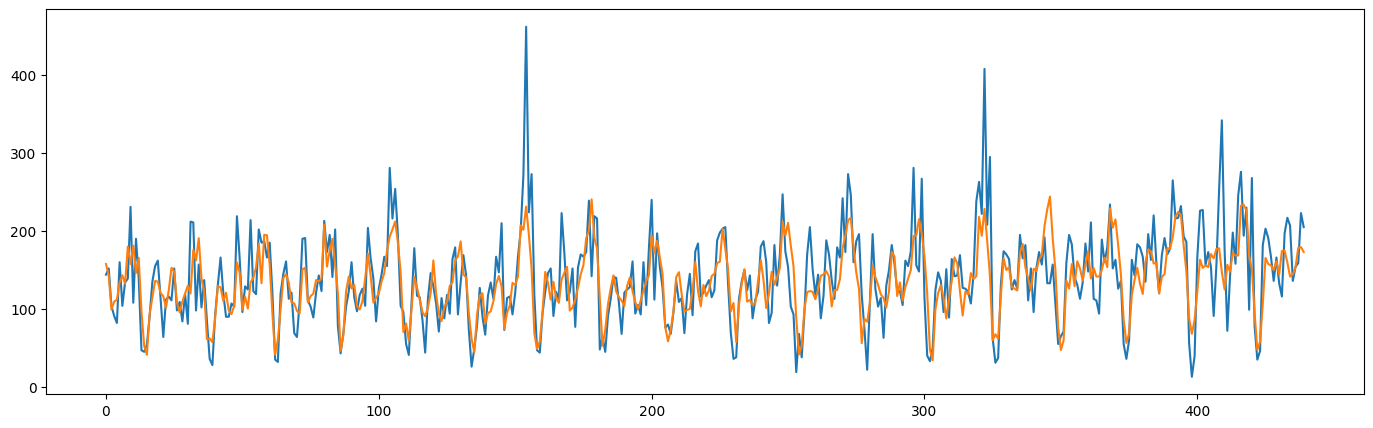

In [42]:
# Визуализация target и prediction для лучшей модели на тестовой выборке

fig, ax = plt.subplots(figsize = (17,5))
ax.plot(target_test.values)
ax.plot(pred_test_list[0])
plt.show()

### Отчет по моделям

In [43]:
# Отчет

report = pd.DataFrame(columns = rmse_test_series.index, index = ['RMSE_train', 'RMSE_test', 'training_time(sec.)', 'predict_time(sec.)'])
report.loc['RMSE_test', :] = sort_rmse
report.loc['RMSE_train', :] = rmse_train_series
report.loc['training_time(sec.)', :] = time_fit_series
report.loc['predict_time(sec.)', :] = time_pred_series
report

,LGB,RandomForest,CatBoost,LinRegression,ElasticNetCV
RMSE_train,12.403751,12.30551,20.29278,25.844386,26.224525
RMSE_test,40.287981,41.253965,43.493546,45.21464,45.406281
training_time(sec.),0.36176,11.893087,0.457654,0.008032,0.102058
predict_time(sec.),0.015489,0.143109,0.00296,0.00188,0.001931


<b>Все модели подходят под условие проекта</b>  

**Лучшее Качество:  
LGB, RMSE = 40.465906**  	


## Общий вывод по проекту!

<div style="border:solid gray 2px; padding: 20px">  
    
<b> В данном Проекте</b>  для того, чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
    
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  

1. Выполнили ресемплирование временного ряда по одному часу.  
2. Выявили:
    - Тренд (плавное изменение среднего значения ряда без повторяющихся закономерностей) увеличения количества заказов в течение всего времени!
    - Сезонность:  Пиковые значения количества заказов приходится в полночь. Минимальные значения в 6 часов утра
3. Провели обучение разных моделей с различными гиперпараметрами.  
(**LGB, RandomForest, CatBoost, LinRegression, ElasticNetCV**)
4. Все модели на тестовой выборке дали качество приемлемое для условия проекта  
Лучше всех прогнозирует **LGB, RMSE = 40.287981**

